In [1]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from sklearn import metrics

In [2]:
all_cn_data_fp = "/Users/massoudmaher/data/sc_1935_1936_1937_cn_data_qc.csv"
all_cn_data = pd.read_csv(all_cn_data_fp)
all_cn_data = all_cn_data.iloc[:,1:]
###
all_cn_data = all_cn_data[all_cn_data["chr"]=="X"]

In [3]:
#all_cn_data = all_cn_data[all_cn_data["cell_id"].isin(all_cn_data["cell_id"].unique()[:10])]
#all_cn_data["cell_id"].unique()

In [4]:
hmmcopy_tickets = ['SC-1935', 'SC-1936', 'SC-1937']
sample_ids = [["SA922"], ['SA921'], ['SA1090']]

# spike in params
total_ncells = 100
proportions = [0.3, 0.3, 0.4]

# bhc params
n_states = 12
alpha = 0.3
prob_cn_change = 0.8
bhc_incon = 2 # inconsistent score used for making clusters from bhc
bhc_depth = 2 

# naive clusering params
naive_method = "complete"
naive_metric = "cityblock"
naive_incon = 1.1
naive_depth = 2

# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

In [5]:
subsample = utils.get_cn_data_submixture(all_cn_data, 20, hmmcopy_tickets, sample_ids, proportions=proportions)

mixed_cn_data = subsample["mixed_cn_data"]
mixed_cn_data["origin_id_int"] = mixed_cn_data["origin_id"].factorize()[0]
cell_counts = subsample["cell_counts"]

/Users/massoudmaher/Documents/Code/scgenome/scgenome/utils.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  jira_cn_data[origin_field_name] = hmmcopy_tickets[i]


In [6]:
start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(mixed_cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change)
)
print(f"{time.time()-start}s for BHC on {total_ncells} cells")

0.44493675231933594s for BHC on 100 cells


In [7]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(lbhc_plot_data[:,2]) # Log because the highest link is way higher

naive_linkage = sch.linkage(measurement, method=naive_method, metric=naive_metric)
##
naive_linkage[:,2] = naive_linkage[:,2] + 1
lnaive_linkage = naive_linkage.copy()
lnaive_linkage[:,2] = np.log(lnaive_linkage[:,2])

In [8]:
def apply_fn(row):
    if row["transform"] == "log":
        df = lbhc_plot_data
    else:
        df = bhc_plot_data
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["bhc_fcluster"] = params.apply(apply_fn, axis=1)
params["bhc_num_clusters"] = params["bhc_fcluster"].apply(lambda x: len(set(x)))

def apply_fn(row):
    if row["transform"] == "log":
        df = lnaive_linkage
    else:
        df = naive_linkage
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["naive_fcluster"] = params.apply(apply_fn, axis=1)
params["naive_num_clusters"] = params["naive_fcluster"].apply(lambda x: len(set(x)))

params.head()

,transform,criterion,threshold,bhc_fcluster,bhc_num_clusters,naive_fcluster,naive_num_clusters
0,log,inconsistent,0.025,"[1, 2, 1, 4, 3, 2, 9, 3, 5, 5, 10, 7, 8, 10, 8...",11,"[4, 3, 4, 6, 2, 3, 9, 2, 8, 8, 5, 8, 7, 5, 7, ...",9
1,log,inconsistent,0.075,"[1, 2, 1, 4, 3, 2, 9, 3, 5, 5, 10, 7, 8, 10, 8...",11,"[4, 3, 4, 6, 2, 3, 9, 2, 8, 8, 5, 8, 7, 5, 7, ...",9
2,log,inconsistent,0.125,"[1, 2, 1, 4, 3, 2, 9, 3, 5, 5, 10, 7, 8, 10, 8...",11,"[4, 3, 4, 6, 2, 3, 9, 2, 8, 8, 5, 8, 7, 5, 7, ...",9
3,log,inconsistent,0.175,"[1, 2, 1, 4, 3, 2, 9, 3, 5, 5, 10, 7, 8, 10, 8...",11,"[4, 3, 4, 6, 2, 3, 9, 2, 8, 8, 5, 8, 7, 5, 7, ...",9
4,log,inconsistent,0.225,"[1, 2, 1, 4, 3, 2, 9, 3, 5, 5, 10, 7, 8, 10, 8...",11,"[4, 3, 4, 6, 2, 3, 9, 2, 8, 8, 5, 8, 7, 5, 7, ...",9


/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


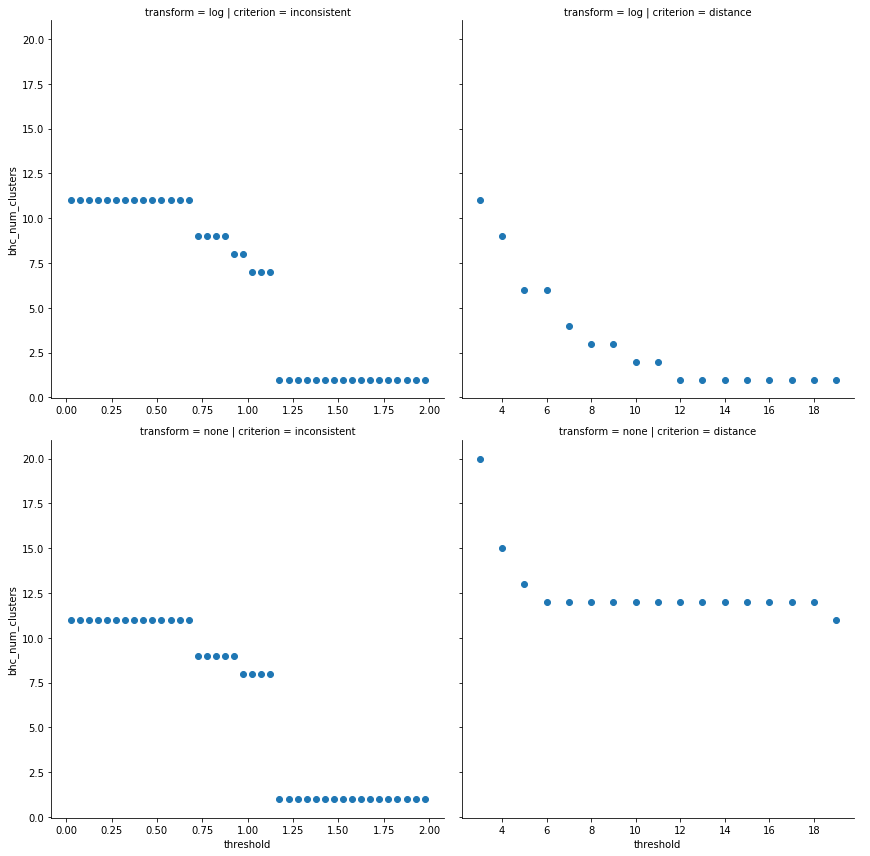

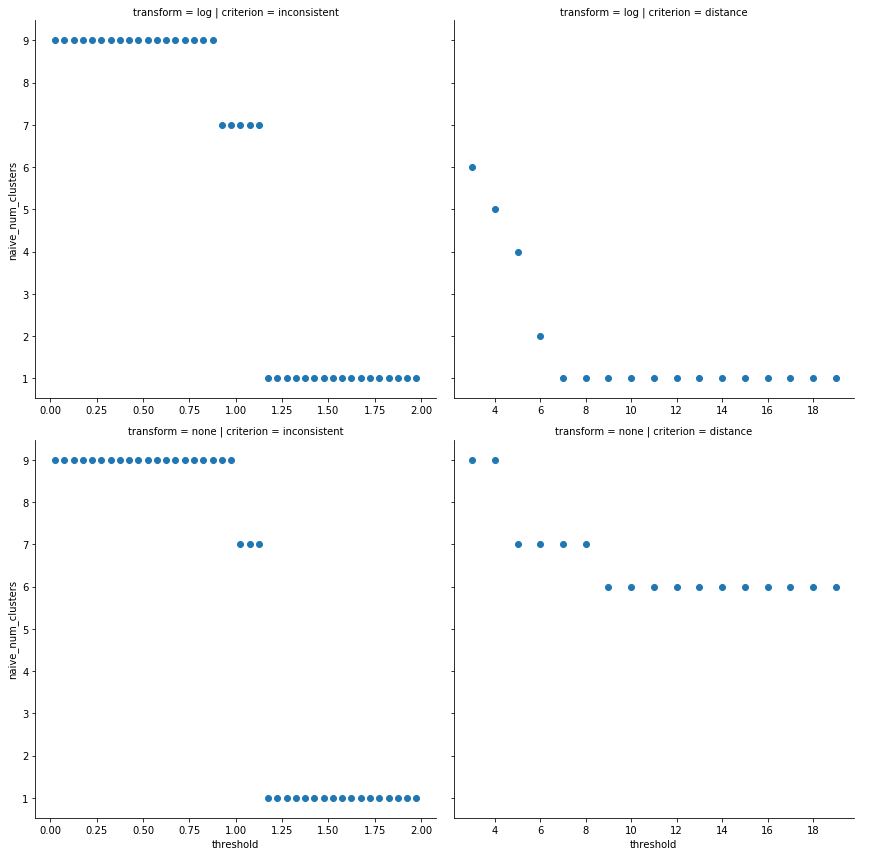

In [9]:
g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "bhc_num_clusters")

g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "naive_num_clusters")

## Rightmost bar represents where sample originally came frome

In [31]:
mixed_cn_data

,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id,origin_id,origin_id_int
607758,X,1,500000,689,-1.000000,NaN,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0
607759,X,500001,1000000,1109,0.458294,2.530674,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0
607760,X,1000001,1500000,599,-1.000000,NaN,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0
607761,X,1500001,2000000,1088,0.481712,2.461374,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0
607762,X,2000001,2500000,960,-1.000000,NaN,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0
607763,X,2500001,3000000,1027,0.448584,2.364590,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0
607764,X,3000001,3500000,1044,0.414510,2.547070,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0
607765,X,3500001,4000000,867,0.437568,2.024495,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0
607766,X,4000001,4500000,1092,0.379672,2.970816,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0
607767,X,4500001,5000000,934,0.373268,2.609714,3,SA922-A90554B-R35-C14,SA922,A90554B,SC-1935,0


ordering
[ 0  2  1  6  4  3 13  5  8  9 16 11 14 17 15 10 12  7 18 19]
plot_data
cell_id             SA922-A90554B-R35-C14 SA922-A90554B-R24-C17  \
bhc_cluster_id                          4                     2   
origin_id_int                           0                     0   
cell_order                             0                     2    
chr_index start                                                   
22        1                             3                     2   
          500001                        3                     2   
          1000001                       3                     2   
          1500001                       3                     2   
          2000001                       3                     2   
          2500001                       3                     2   
          3000001                       3                     2   
          3500001                       3                     2   
          4000001                       3       

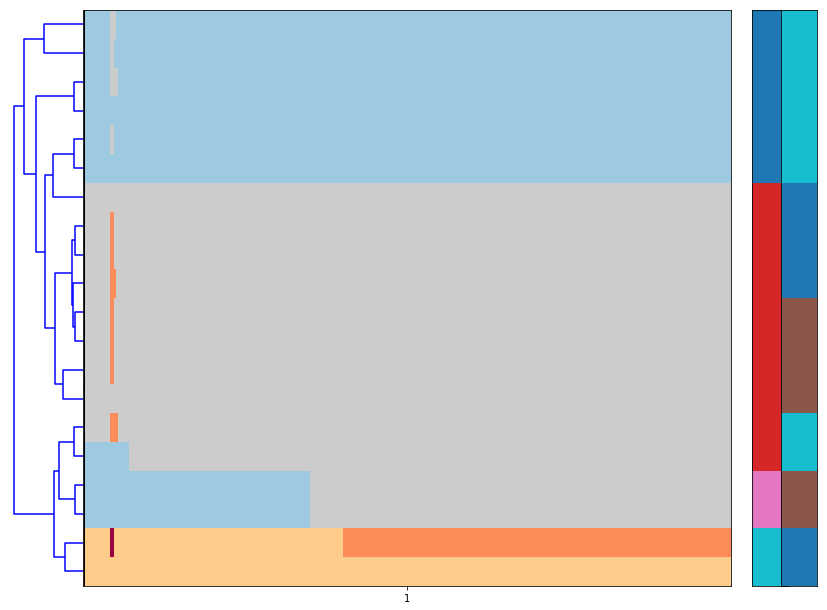

In [10]:
cmixed_cn_data = mixed_cn_data.copy()
clustering = sch.fcluster(lbhc_plot_data, 7, criterion="distance")
cmixed_cn_data = cncluster.prune_cluster(clustering, bhc_cell_ids, mixed_cn_data)

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cmixed_cn_data, "state", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int")

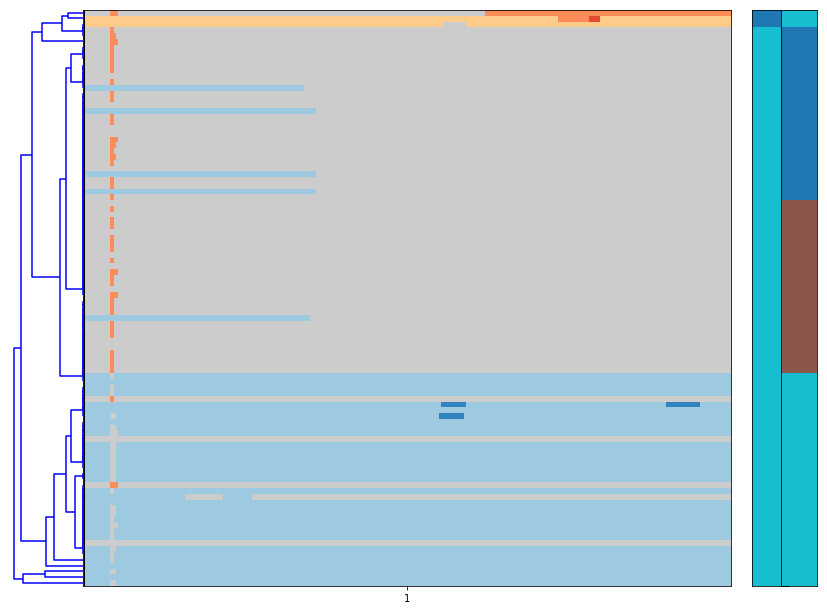

In [12]:
naive_clusters = sch.fcluster(lnaive_linkage, 6, criterion="distance")
assert len(set(naive_clusters)) > 1
nmixed_cn_data = cncluster.prune_cluster(naive_clusters, bhc_cell_ids, mixed_cn_data, 
                                         cluster_field_name="naive_cluster_id")
fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, nmixed_cn_data, "state", cluster_field_name="naive_cluster_id",
    linkage=lnaive_linkage, origin_field_name="origin_id_int")

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../scg/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../scg/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/numba/compiler

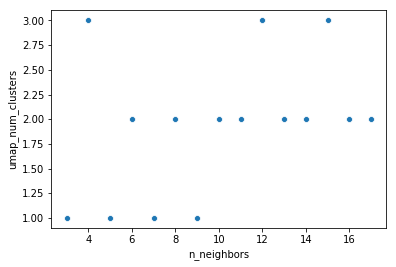

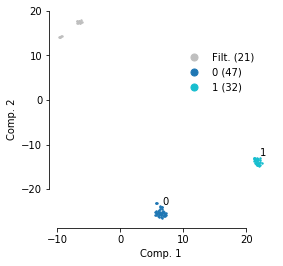

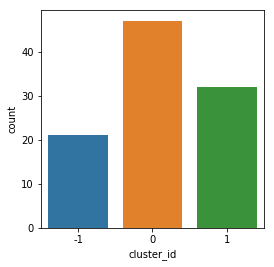

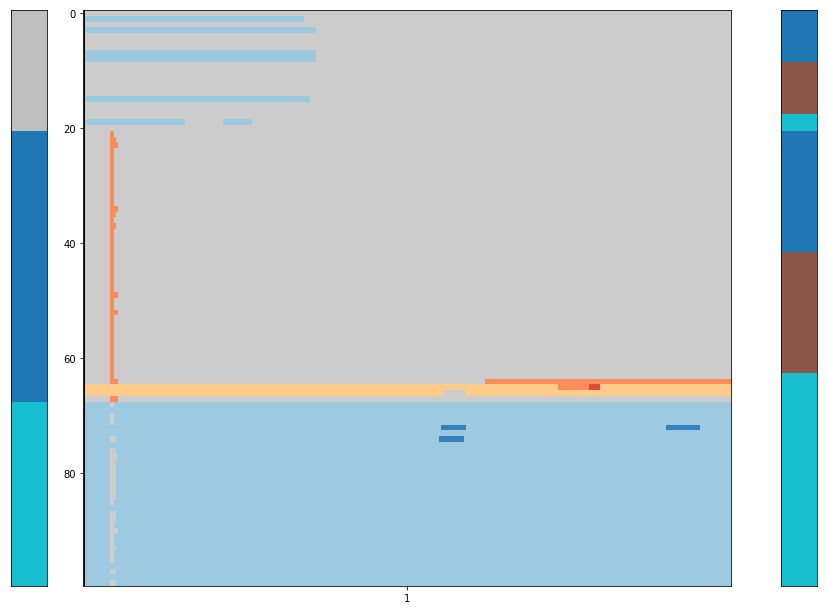

In [13]:
umap_params = utils.expand_grid({"n_neighbors": np.arange(3,18,step=1)})
def apply_fn(row):
    return cncluster.umap_hdbscan_cluster(matrix_data["state"], n_neighbors=row["n_neighbors"])

umap_params["umap_clusters"] = umap_params.apply(apply_fn, axis=1)
umap_params["umap_num_clusters"] = umap_params["umap_clusters"].apply(lambda x: len(set(x["cluster_id"])))

sns.scatterplot(data=umap_params, x="n_neighbors", y="umap_num_clusters")

umap_df = cncluster.umap_hdbscan_cluster(matrix_data["state"], n_neighbors=15)
umixed_cn_data = mixed_cn_data.merge(umap_df, how="inner")

fig = plt.figure(figsize=(4, 4))
cncluster.plot_umap_clusters(plt.gca(), umap_df)

fig = plt.figure(figsize=(4, 4))
sns.barplot(x='cluster_id', y='count', data=umap_df.groupby('cluster_id').size().rename('count').reset_index())


fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, umixed_cn_data, "state", cluster_field_name="cluster_id",
    linkage=None, origin_field_name="origin_id_int")
#def umap_hdbscan_cluster(
#        cn,
#        n_components=2,
#        n_neighbors=15,
#        min_dist=0.1,
#):

In [14]:
display(umixed_cn_data.head())
display(nmixed_cn_data.head())
display(cmixed_cn_data.head())
print(cmixed_cn_data.shape)

,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id,origin_id,origin_id_int,cluster_id,umap1,umap2
0,X,1,500000,76,-1.000000,NaN,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,0,6.177301,-25.28717
1,X,500001,1000000,107,0.458294,1.593015,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,0,6.177301,-25.28717
2,X,1000001,1500000,85,-1.000000,NaN,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,0,6.177301,-25.28717
3,X,1500001,2000000,145,0.481712,2.270180,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,0,6.177301,-25.28717
4,X,2000001,2500000,117,-1.000000,NaN,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,0,6.177301,-25.28717


,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id,origin_id,origin_id_int,naive_cluster_id
55424,X,1,500000,76,-1.000000,NaN,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2
55425,X,500001,1000000,107,0.458294,1.593015,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2
55426,X,1000001,1500000,85,-1.000000,NaN,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2
55427,X,1500001,2000000,145,0.481712,2.270180,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2
55428,X,2000001,2500000,117,-1.000000,NaN,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2


,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id,origin_id,origin_id_int,bhc_cluster_id
55424,X,1,500000,76,-1.000000,NaN,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2
55425,X,500001,1000000,107,0.458294,1.593015,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2
55426,X,1000001,1500000,85,-1.000000,NaN,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2
55427,X,1500001,2000000,145,0.481712,2.270180,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2
55428,X,2000001,2500000,117,-1.000000,NaN,2,SA922-A90554B-R27-C62,SA922,A90554B,SC-1935,0,2


(31100, 13)
